<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/datamining/data_mining_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting with boosting...

## Previous steps

We import the Python libraries that we will need in this notebook


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from scipy import stats
import random
from typing import Optional
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import plot_tree
from typing import Optional

Auxiliary functions to show samples and boundaries. Extracted from https://geoffruddock.com/adaboost-from-scratch-in-python/

In [ ]:
def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

First of all, red wines features from the wine quality dataset are loaded  

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wines_red = pd.read_csv(dataset_url, sep=';')
wines_red['type']='red'
wines_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Now, it's the turn for the white wines...

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
wines_white = pd.read_csv(dataset_url, sep=';')
wines_white['type']='white'
wines_white.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


Finally, we merge both to create the Wine dataset


In [ ]:
wines = pd.concat([wines_red, wines_white],ignore_index=True)
wines.head

<bound method NDFrame.head of       fixed acidity  volatile acidity  citric acid  ...  alcohol  quality   type
0               7.4              0.70         0.00  ...      9.4        5    red
1               7.8              0.88         0.00  ...      9.8        5    red
2               7.8              0.76         0.04  ...      9.8        5    red
3              11.2              0.28         0.56  ...      9.8        6    red
4               7.4              0.70         0.00  ...      9.4        5    red
...             ...               ...          ...  ...      ...      ...    ...
6492            6.2              0.21         0.29  ...     11.2        6  white
6493            6.6              0.32         0.36  ...      9.6        5  white
6494            6.5              0.24         0.19  ...      9.4        6  white
6495            5.5              0.29         0.30  ...     12.8        7  white
6496            6.0              0.21         0.38  ...     11.8        6  whit

## Preparing the dataset

We create the *quality_label* based on the quality score according to:

*   Low for less or equal to 5
*   Medium between 6 and 7
*   High for more than 7

Moreover, the *quality_binary* label is created to explain visually the bagging method



In [ ]:
wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
wines['quality_binary'] = wines.quality.apply(lambda q: -1 if q <= 5 else 1 if q > 7 else 0)
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,quality_label,quality_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,low,-1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,low,-1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,low,-1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red,medium,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,low,-1


*Nan* data is deleted and number of samples per quality are shown

In [ ]:
wines.dropna().quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In order to conveniently illustrate the techniques, we will proceed to simplify the dataset. For this purpose, we are only interested in samples with high and low wine quality, eliminating those of medium level. In addition, we keep only the *volatile_acidity* and *alcohol* characteristics to form a two-dimensional input space.

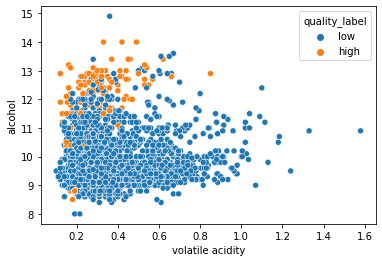

In [ ]:
wines_binary = wines.drop(wines[wines.quality_binary == 0].index)
sns.scatterplot(data=wines_binary,x="volatile acidity",y="alcohol",hue=wines_binary['quality_label'])

Since there are many more low quality samples, we will balance the dataset by keeping very few samples of both.

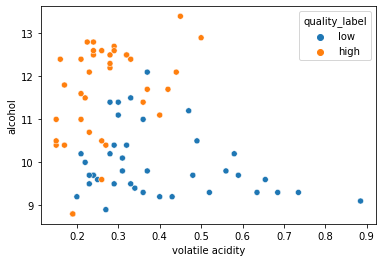

In [ ]:
g = wines_binary.groupby('quality_binary')
wines_binary_balanced = g.apply(lambda x: x.sample(int(g.size().min()/5),random_state=9).reset_index(drop=True))
sns.scatterplot(data=wines_binary_balanced,x="volatile acidity",y="alcohol",hue=wines_binary_balanced['quality_label'])

Finally, we scale the data...

In [ ]:
X=wines_binary_balanced[["volatile acidity", "alcohol"]]
y=wines_binary_balanced['quality_binary'].to_numpy()

sc = StandardScaler()
sc.fit(X)
X_scaled = pd.DataFrame(sc.transform(X),columns = X.columns)

## Adabost ensemble from scratch

We are going to generate a boosting ensemble from scratch (specifically, Adaboost). The code has been extracted from https://geoffruddock.com/adaboost-from-scratch-in-python/ and adapted the learning rate from [Xavier's blog](https://xavierbourretsicotte.github.io/AdaBoost.html)

---



In [ ]:
class AdaBoost:
    """ AdaBoost enemble classifier from scratch """

    def __init__(self):
        self.stumps = None
        self.stump_weights = None
        self.errors = None
        self.sample_weights = None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

The assembly consists of decision trees. We must indicate the number of models we want and the number of samples that the bootstrap will contain.


*   `X`: Data
*   `y`: labels
*   `num_models`: number of models in the ensemble
*   `learning_rate`: learning rate


In [ ]:
from sklearn.tree import DecisionTreeClassifier

def fit(self, X: np.ndarray, y: np.ndarray, num_models: int, learning_rate: float):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    # init numpy arrays
    self.sample_weights = np.zeros(shape=(num_models, n))
    self.stumps = np.zeros(shape=num_models, dtype=object)
    self.stump_weights = np.zeros(shape=num_models)
    self.errors = np.zeros(shape=num_models)

    # initialize weights uniformly
    self.sample_weights[0] = np.ones(shape=n) / n

    for t in range(num_models):
        # fit  weak learner
        curr_sample_weights = self.sample_weights[t]
        stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
        stump = stump.fit(X, y, sample_weight=curr_sample_weights)

        # calculate error and stump weight from weak learner prediction
        stump_pred = stump.predict(X)
        err = curr_sample_weights[(stump_pred != y)].sum()
        stump_weight = np.log((1 - err) / err) * learning_rate

        # update sample weights
        new_sample_weights = (
            curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
        )

        new_sample_weights /= new_sample_weights.sum()

        # If not final iteration, update sample weights for t+1
        if t+1 < num_models:
            self.sample_weights[t+1] = new_sample_weights

        # save results of iteration
        self.stumps[t] = stump
        self.stump_weights[t] = stump_weight
        self.errors[t] = err

    return self

The prediction function combines the decisions of the models by means of a weighted majority voting system.

In [ ]:
def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    return np.sign(np.dot(self.stump_weights, stump_preds))

The classification and results in two-dimensional feature space are shown below:

Train error: 19.2%


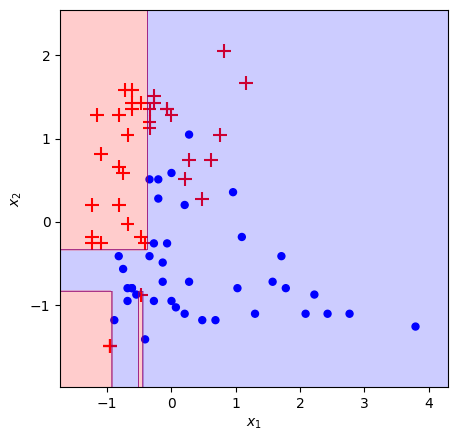

In [ ]:
# assign our individually defined functions as methods of our classifier
AdaBoost.fit = fit
AdaBoost.predict = predict

num_models=10
learning_rate=1
clf = AdaBoost().fit(X_scaled.to_numpy(), y, num_models=num_models, learning_rate=learning_rate)

plot_adaboost(X_scaled.to_numpy(), y, clf)
train_err = (clf.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

Compare the results with the [bagging method](https://colab.research.google.com/drive/1av5WZ4AwxGgPzFHET5XEcOKVFtsLJuc5?authuser=2#scrollTo=LnPT3jJIbT9X&line=5&uniqifier=1) for the same data

## Adaboost ensamble from scratch step by step

To explain the contribution of each model to whole ensamble, we are going to use again the code that has been extracted from https://geoffruddock.com/adaboost-from-scratch-in-python/

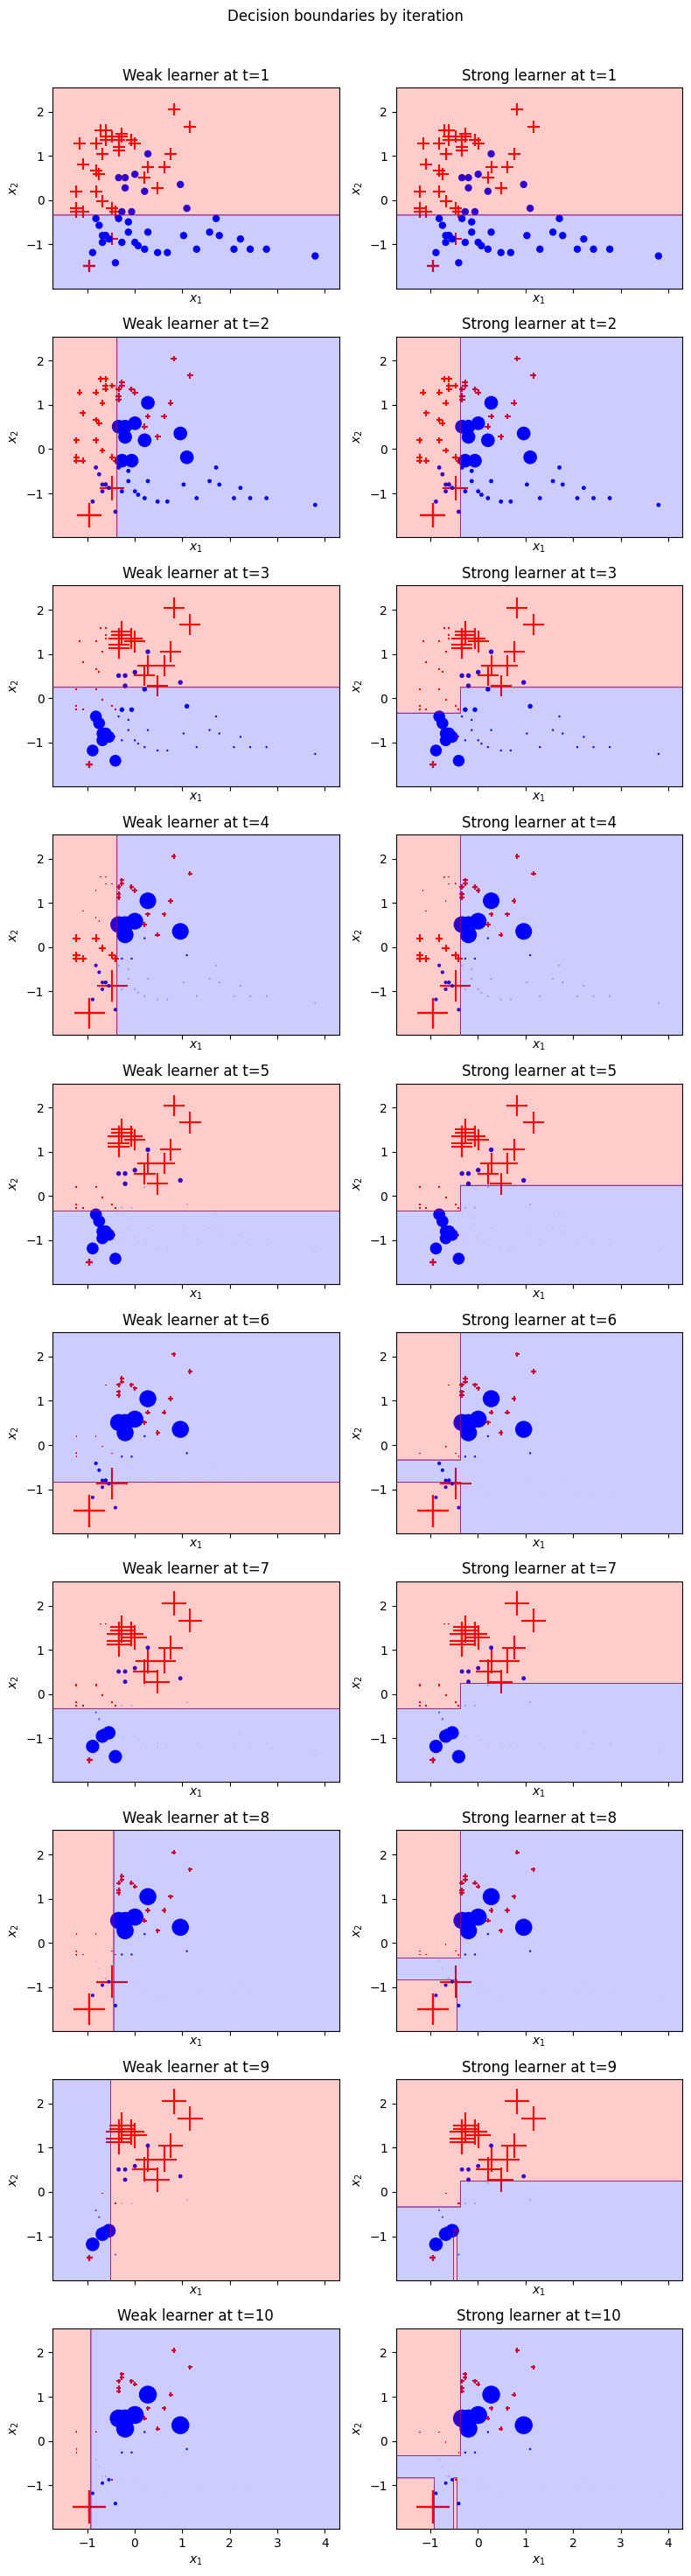

In [ ]:
def truncate_adaboost(clf, t: int):
    """ Truncate a fitted AdaBoost up to (and including) a particular iteration """
    assert t > 0, 't must be a positive integer'
    from copy import deepcopy
    new_clf = deepcopy(clf)
    new_clf.stumps = clf.stumps[:t]
    new_clf.stump_weights = clf.stump_weights[:t]
    return new_clf


def plot_staged_adaboost(X, y, clf, iters=10):
    """ Plot weak learner and cumulaive strong learner at each iteration. """

    # larger grid
    fig, axes = plt.subplots(figsize=(8, iters*3),
                             nrows=iters,
                             ncols=2,
                             sharex=True,
                             dpi=100)

    fig.set_facecolor('white')

    _ = fig.suptitle('Decision boundaries by iteration')
    for i in range(iters):
        ax1, ax2 = axes[i]

        # Plot weak learner
        _ = ax1.set_title(f'Weak learner at t={i + 1}')
        plot_adaboost(X, y, clf.stumps[i],
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax1)

        # Plot strong learner
        trunc_clf = truncate_adaboost(clf, t=i + 1)
        _ = ax2.set_title(f'Strong learner at t={i + 1}')
        plot_adaboost(X, y, trunc_clf,
                      sample_weights=clf.sample_weights[i],
                      annotate=False, ax=ax2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

clf = AdaBoost().fit(X_scaled.to_numpy(), y, num_models=num_models, learning_rate=learning_rate)
plot_staged_adaboost(X_scaled.to_numpy(), y, clf)

## Gradient boosting from scratch

We are going to generate a gradient boosting from scratch, the code has been adapted from https://geoffruddock.com/adaboost-from-scratch-in-python/ and the book  [Machine Learning in Python: Essential Techniques for Predictive Analysis, Michael Bowles](https://www.wiley.com/en-us/Machine+Learning+in+Python%3A+Essential+Techniques+for+Predictive+Analysis-p-9781118961742)

In [ ]:
class GradientBoosting:
    """ Gradient boosting ensemble classifier from scratch """

    def __init__(self):
        self.stumps = None
        self.num_models = None
        self.learning_rate = None

    def _check_X_y(self, X, y):
        """ Validate assumptions about format of input data"""
        assert set(y) == {-1, 1}, 'Response variable must be ±1'
        return X, y

The assembly consists of decision trees. We must indicate the number of models we want.


*   `X`: Data
*   `y`: labels
*   `num_models`: number of models in the ensemble
*   `learning_rate`: learning rate


In [ ]:
def fit(self, X: np.ndarray, y: np.ndarray, num_models: int, learning_rate: float):
    """ Fit the model using training data """

    X, y = self._check_X_y(X, y)
    n = X.shape[0]

    self.num_models = num_models
    self.stumps = np.zeros(shape=num_models, dtype=object)
    self.learning_rate = learning_rate
    #train a series of models on random subsets of the training data

    #initialize residuals to be the labels y
    residuals = y.copy()
    for t in range(num_models):
        stump = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=2)
        stump.fit(X, residuals)
        #make prediction with latest model and add to list of predictions
        latestInSamplePrediction = stump.predict(X)
        #use new predictions to update residuals
        residuals = residuals - learning_rate * latestInSamplePrediction
        self.stumps[t] = stump
    return self

The prediction function combines the decisions of the models by means of a voting system.

In [ ]:
def predict(self, X):
    """ Make predictions using already fitted model """
    stump_preds = np.array([stump.predict(X) for stump in self.stumps])
    predall = sum(stump_preds)*self.learning_rate
    predall = np.where(predall <= 0, -1, predall)
    predall = np.where(predall > 0, 1, predall)
    return predall

The classification and results in two-dimensional feature space are shown below:

Train error: 6.4%


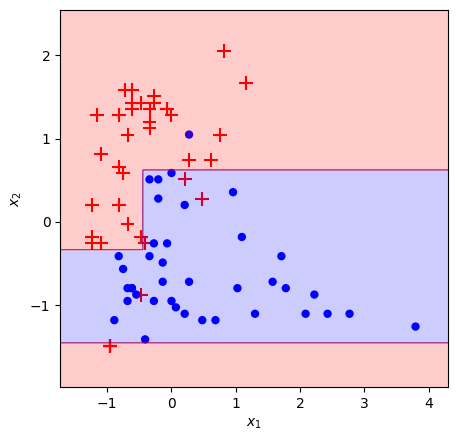

In [ ]:
# assign our individually defined functions as methods of our classifier
GradientBoosting.fit = fit
GradientBoosting.predict = predict

learning_rate=0.8
clf = GradientBoosting().fit(X=X_scaled.to_numpy(), y=y, num_models=num_models, learning_rate=learning_rate)

plot_adaboost(X_scaled.to_numpy(), y, clf)
train_err = (clf.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

## Very simple with **scikit-learn**

Train error: 2.6%


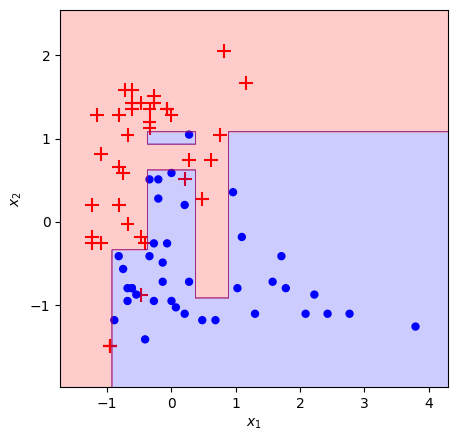

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=num_models).fit(X_scaled, y)
plot_adaboost(X_scaled.to_numpy(), y, adaboost)

train_err = (adaboost.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

Train error: 0.0%


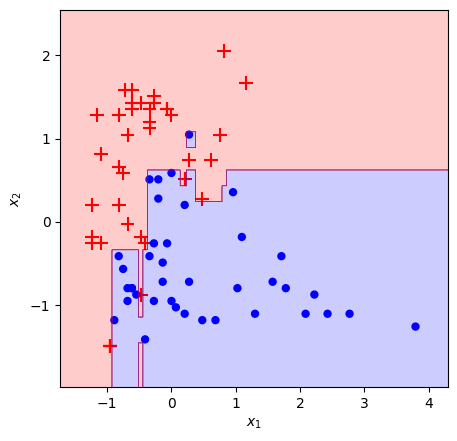

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradientboost = GradientBoostingClassifier(n_estimators=num_models,learning_rate=0.8).fit(X_scaled, y)
plot_adaboost(X_scaled.to_numpy(), y, gradientboost)

train_err = (gradientboost.predict(X_scaled.to_numpy()) != y).mean()
print(f'Train error: {train_err:.1%}')

# Referencias


*   [Machine Learning in Python: Essential Techniques for Predictive Analysis, Michael Bowles](https://www.wiley.com/en-us/Machine+Learning+in+Python%3A+Essential+Techniques+for+Predictive+Analysis-p-9781118961742)
*   [Wines dataset](https://www.kaggle.com/mgmarques/wines-type-and-quality-classification-exercises)
*   [Functions to show data space and boundaries](https://geoffruddock.com/adaboost-from-scratch-in-python/)
*   [Xavier's blog](https://xavierbourretsicotte.github.io/AdaBoost.html)